In [1]:
import math

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras

## Import data

In [2]:
training_df = pd.read_csv("./Google_Stock_Price_Train.csv")

In [3]:
training_df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [4]:
training_df.tail()

,Date,Open,High,Low,Close,Volume
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"
1257,12/30/2016,782.75,782.78,770.41,771.82,"1,770,000"


In [5]:
training_data = training_df['Open'].values.reshape(-1, 1)

## Constants

In [6]:
EPOCHS = 100
SEQ_SIZE = 60
UNITS = 60
BATCH_SIZE = 32

## Preprocessing

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler = MinMaxScaler()

In [9]:
scaled_training_data = scaler.fit_transform(training_data)

In [10]:
def generate_seqs(data, sequence_size):
    seqs = data.shape[0] - sequence_size
    
    for start in range(seqs):
        end = start + sequence_size

        yield data[start:end], data[end:end + 1, 0]

In [11]:
x_data = []
y_data = []

for x, y in generate_seqs(scaled_training_data, SEQ_SIZE):
    x_data.append(x)
    y_data.append(y)

X_train, y_train = np.array(x_data), np.array(y_data)

In [12]:
X_train.shape

(1198, 60, 1)

In [13]:
y_train.shape

(1198, 1)

In [14]:
def build_model(units=UNITS, optimizer='rmsprop'):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=units, return_sequences=True, input_shape=(SEQ_SIZE, 1), dropout=0.2))
    model.add(keras.layers.LSTM(units=units, return_sequences=True, dropout=0.2))
    model.add(keras.layers.LSTM(units=units, return_sequences=True, dropout=0.2))
    model.add(keras.layers.LSTM(units=units, dropout=0.2))
    model.add(keras.layers.Dense(1))
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error'
    )
    return model

In [15]:
model = build_model()

model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/100
1198/1198 [==============================]1198/1198 [==============================] - 9s 7ms/step - loss: 0.0647

Epoch 2/100
1198/1198 [==============================]1198/1198 [==============================] - 7s 6ms/step - loss: 0.0489

Epoch 3/100
1198/1198 [==============================]1198/1198 [==============================] - 7s 6ms/step - loss: 0.0429

Epoch 4/100
1198/1198 [==============================]1198/1198 [==============================] - 7s 6ms/step - loss: 0.0330

Epoch 5/100
1198/1198 [==============================]1198/1198 [==============================] - 7s 6ms/step - loss: 0.0212

Epoch 6/100
1198/1198 [==============================]1198/1198 [==============================] - 7s 6ms/step - loss: 0.0199

Epoch 7/100
1198/1198 [==============================]1198/1198 [==============================] - 7s 6ms/step - loss: 0.0172

Epoch 8/100
1198/1198 [==============================]1198/1198 [==============================] - 7s 6ms/step 

In [16]:
testing_df = pd.read_csv("./Google_Stock_Price_Test.csv")

In [17]:
testing_df

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"
5,1/10/2017,807.86,809.13,803.51,804.79,"1,176,800"
6,1/11/2017,805.00,808.15,801.37,807.91,"1,065,900"
7,1/12/2017,807.14,807.39,799.17,806.36,"1,353,100"
8,1/13/2017,807.48,811.22,806.69,807.88,"1,099,200"
9,1/17/2017,807.08,807.14,800.37,804.61,"1,362,100"


In [18]:
len(testing_df)

20

## Rely on last 60 values to predict next sequence

In [19]:
next_batch = None
predicted_value = None
predicted_values = []

for i in range(len(testing_df)):
    if next_batch is None:
        next_batch = scaled_training_data[-SEQ_SIZE:]
    else:
        next_batch = np.append(next_batch[1:], predicted_value)

    predicted_value = model.predict(next_batch.reshape(-1, 60, 1))
    predicted_values.append(predicted_value)

predicted_values = np.array(predicted_values).reshape(-1, 1)

In [20]:
predicted_values = scaler.inverse_transform(predicted_values)

In [21]:
predicted_values

array([[713.49   ],
       [660.1982 ],
       [648.8437 ],
       [645.54517],
       [643.9549 ],
       [642.6904 ],
       [640.2477 ],
       [638.37427],
       [636.65247],
       [634.40686],
       [630.69696],
       [624.43225],
       [614.4176 ],
       [599.1078 ],
       [577.5736 ],
       [551.23364],
       [522.6292 ],
       [493.92337],
       [465.9089 ],
       [438.29193]], dtype=float32)

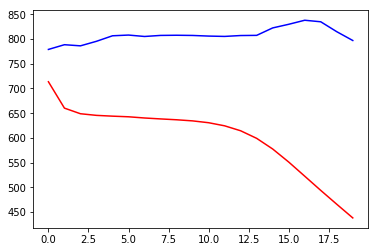

In [22]:
plt.plot(predicted_values, 'r')
plt.plot(testing_df['Open'].values, 'b')

## Feed original value every time

In [23]:
df = pd.concat((training_df['Open'], testing_df['Open']), axis=0)

In [24]:
inputs = df[len(df) - len(testing_df) - SEQ_SIZE:].values

In [25]:
inputs = inputs.reshape(-1, 1)

In [26]:
inputs.shape

(80, 1)

In [27]:
scaled_tesing_data = scaler.transform(inputs)

In [28]:
x_data = []

for x, _ in generate_seqs(scaled_tesing_data, SEQ_SIZE):
    x_data.append(x)

X_test = np.array(x_data)

In [29]:
X_test

array([[[0.9299055 ],
        [0.93113327],
        [0.92750577],
        ...,
        [0.95725128],
        [0.93796041],
        [0.93688146]],

       [[0.93113327],
        [0.92750577],
        [0.94415507],
        ...,
        [0.93796041],
        [0.93688146],
        [0.92955205]],

       [[0.92750577],
        [0.94415507],
        [0.93876032],
        ...,
        [0.93688146],
        [0.92955205],
        [0.94731751]],

       ...,

       [[0.96054394],
        [0.9371419 ],
        [0.92841729],
        ...,
        [1.01045465],
        [1.02407173],
        [1.03930724]],

       [[0.9371419 ],
        [0.92841729],
        [0.90804747],
        ...,
        [1.02407173],
        [1.03930724],
        [1.03354044]],

       [[0.92841729],
        [0.90804747],
        [0.8771858 ],
        ...,
        [1.03930724],
        [1.03354044],
        [0.99624228]]])

In [30]:
X_test.shape

(20, 60, 1)

In [31]:
predicted_values = model.predict(X_test)
predicted_values = scaler.inverse_transform(predicted_values)

In [32]:
predicted_values

array([[713.49005],
       [708.75006],
       [717.9437 ],
       [714.01776],
       [722.97363],
       [729.4856 ],
       [729.2834 ],
       [726.02136],
       [727.5605 ],
       [726.69354],
       [726.711  ],
       [725.4068 ],
       [724.9132 ],
       [726.1116 ],
       [725.60925],
       [738.2827 ],
       [740.46967],
       [747.04816],
       [741.5001 ],
       [725.2431 ]], dtype=float32)

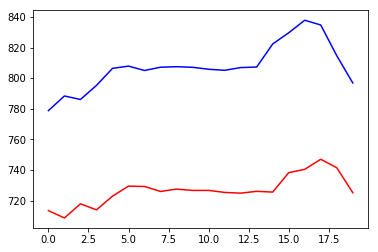

In [33]:
plt.plot(predicted_values, 'r')
plt.plot(testing_df['Open'].values, 'b')